# Assignment 4
 - a) We will be working with the **AFHQ (Animal Faces-HQ)** dataset: https://github.com/clovaai/stargan-v2
    - Approx 15.000 images of animal faces (cat, dog, tiger, ...)
    - Downsample the images to 64x64
 - b) Write **Convolutional** Variational Autoencoder (ConvVAE)
      - Use Conv. layers for encoder and Transposed-Conv. layers for decoder.
      - You are only allowed to use linear layers for estimating the mean and standard deviation. Everything else should be convolutional.
 - c) Investigate the importance of the KL-divergence weight. For this purpose, train multiple models (at least 4) using different weighting values and investigate how this value affects the generation performance.
 - d) Generate new images by sampling latent vectors, investigate latent space and visualize some interpolations.
 - e) Compare the models from b) and c)
     - Qualitative comparison. Which images look better?
     - Quantitative comparison between models using the Fréchet Inception Distance: https://arxiv.org/abs/1706.08500
     - Log generated images and losses into the Tensorboard/W&B
     
     
**Extra Point:**
 - Extend your ConvVAE for Image generation conditioned on a given class. The AFHQ dataset has 3 classes: 'cat', 'dog', and 'wildlife'
 - Train your Conditional-ConvVAE
 - Show that you can generate images conditioned on a label
 - Tutorial: https://ijdykeman.github.io/ml/2016/12/21/cvae.html

In [2]:
import os
import shutil
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, models, transforms
from torchvision.utils import save_image
from utils import *
print(torch.cuda.is_available())

2025-06-02 10:06:28.458179: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-02 10:06:29.083530: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


True


In [16]:
config={"data_dir": "data/AFHQ",
        "img_size": 64}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Computing mean, std of dataset

In [9]:
dataset = datasets.ImageFolder(
    root=config["data_dir"]+"/train",
    transform=transforms.ToTensor()  # Converts images to [C, H, W] with values in [0, 1]
)
"""mean, std = compute_stats(dataset)
print(f"Mean (R, G, B): {mean.tolist()}")
print(f"Std  (R, G, B): {std.tolist()}")
"""

mean = torch.tensor([0.5018709301948547, 0.4601306915283203, 0.3988320827484131])
std = torch.tensor([0.22490206360816956, 0.2184346467256546, 0.21783076226711273])
"""computed:
Mean (R, G, B): [0.5018709301948547, 0.4601306915283203, 0.3988320827484131]
Std  (R, G, B): [0.22490206360816956, 0.2184346467256546, 0.21783076226711273]
"""

'computed:\nMean (R, G, B): [0.5018709301948547, 0.4601306915283203, 0.3988320827484131]\nStd  (R, G, B): [0.22490206360816956, 0.2184346467256546, 0.21783076226711273]\n'

## Preparing data loaders

In [11]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(config["img_size"]),
        transforms.ToTensor(),
        transforms.Normalize(mean,std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(config["img_size"]),
        transforms.ToTensor(),
        transforms.Normalize(mean,std)
    ]),
}

train_dataset = datasets.ImageFolder(os.path.join(config["data_dir"], "train"), data_transforms["train"])
valid_dataset = datasets.ImageFolder(os.path.join(config["data_dir"], "test"), data_transforms["val"])

N_train = len(train_dataset)
N_valid = len(valid_dataset)
print(f"Training set size: {N_train} images")
print(f"Valdiation set size: {N_valid} images")

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=4)

class_names = train_dataset.classes
print(class_names)

Training set size: 14336 images
Valdiation set size: 1467 images
['cat', 'dog', 'wild']


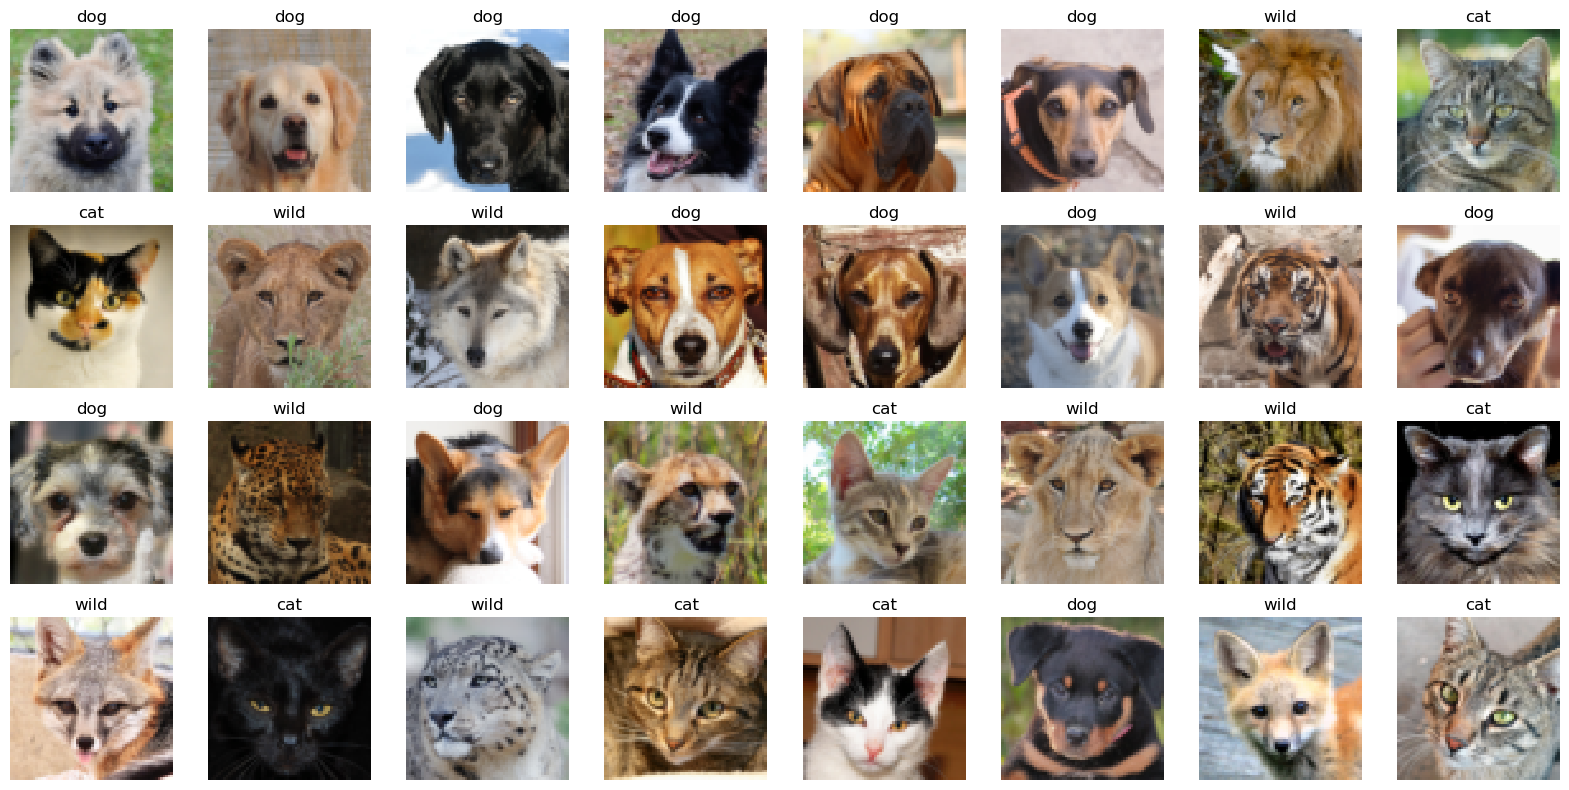

In [15]:
def show_grid(data, titles=None):
    """Imshow for Tensor."""
    data = data.numpy().transpose((0, 2, 3, 1))
    data = std * data + mean  # IMPORTANT! If you normalize imgs in the DataLoader, undo the norm. for visualization
    data = np.clip(data, 0, 1)
    
    plt.figure(figsize=(8*2, 4*2))
    for i in range(32):
        plt.subplot(4,8,i+1)
        plt.imshow(data[i])
        plt.axis("off")
        if titles is not None:
            plt.title(titles[i])
    plt.tight_layout()
    plt.show()
            
# Get a batch of training data and displaying it
inputs, classes = next(iter(train_loader))
#inputs, classes = next(iter(valid_loader))
titles = [class_names[x] for x in classes]

show_grid(inputs, titles=titles)

## Convolutional Variational Auto Encoders

In [ ]:
class ConvolutionalVAE(nn.Module):
    """
    Implementation of a fully connect autoencoder for 
    denoising  MNIST images
    """
    
    def __init__(self, in_size=(1, 32, 32), sizes=[1024, 128, 10], act_final="Sigmoid" ,act_hidden="ReLU", kernel_size=3, padding=1):
        """ Model initlaizer """
        assert np.prod(in_size) == sizes[0]
        super().__init__()
        
        self.in_size = in_size
        self.sizes = sizes
        self.activation_hidden = get_activation(act_hidden)
        self.activation_final = get_activation(act_final)
        
        self.encoder = self._make_encoder()
        self.decoder = self._make_decoder()
        self.fc_mu = nn.Linear(sizes[-2], sizes[-1])
        self.fc_sigma = nn.Linear(sizes[-2], sizes[-1])
        return
        
    def _make_encoder(self):
        """ Defining encoder """
        layers = [nn.Flatten()]
        for i in range(len(self.sizes)-2):
            layers.append( nn.Conv2d(in_channels=self.sizes[i], out_channels=self.sizes[i+1], kernel_size=self.kernel_size, padding=self.padding) )
            layers.append( self.activation_hidden )
        encoder = nn.Sequential(*layers)
        return encoder
    
    def _make_decoder(self):
        """ Defining decoder """
        layers = []
        for i in range(1, len(self.sizes)):
            layers.append( nn.Conv2d(in_channels=self.sizes[-i], out_channels=self.sizes[-i-1], kernel_size=self.kernel_size, padding=self.padding) )
            layers.append( self.activation_hidden )
        layers = layers[:-1] + [self.activation_final]
        decoder = nn.Sequential(*layers)
        return decoder
    
    
    def forward(self, x):
        """ Forward pass """
        x_enc = self.encoder(x)
        mu = self.fc_mu(x_enc)
        log_var = self.fc_sigma(x_enc)
        z = reparameterize(mu, log_var)
        x_hat_flat = self.decoder(z)
        x_hat = x_hat_flat.view(-1, *self.in_size)
        return x_hat, (z, mu, log_var)